In [0]:
# Imports needed.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get FASHION-mnist from Keras datasets.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Set the training parameters
num_steps = 100000 
batch_size = 128  
beta1 = 0.5
lr_generator = 0.0005
lr_discriminator = 0.0005

# Set the network parameters
image_dim = 784              # 28*28 pixels * 1 channel
noise_dim = 128              # Noise data points

In [0]:
def next_batch(num, data):
    #This function returns a total of `num` random samples and labels. 
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]

    return data_shuffle


In [0]:
# Functions for visualizing the results.

def plot_fun1():
  # Generate images from noise, using the generator network.
  n = 6
  canvas = np.empty((28 * n, 28 * n))
  for i in range(n):
      # Noise input.
      z = np.random.uniform(-1., 1., size=[n, noise_dim])
      # Generate image from noise.
      g = sess.run(z_sample, feed_dict={noise_input: z, is_training:False})
      # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
      g = (g + 1.) / 2.
      for j in range(n):
          # Draw the generated digits
          canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

  plt.figure(figsize=(n, n))
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.show()
  
  
def plot_fun2():
  n=2
  for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[1, noise_dim])
    # Generate image from noise.
    g = sess.run(z_sample, feed_dict={noise_input: z, is_training:False})
    # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = (g + 1.) / 2.
    plt.figure(figsize=(5, 5))
    plt.imshow(g.reshape([28,28]), origin="upper", cmap="gray")
    plt.show()

In [0]:
# Loss functions based on Algorithm 3

def gen_difs(z, x, batch_size):
  
  fake_difs = tf.expand_dims(z, axis=1) - tf.expand_dims(z, axis=0)
  fake_mask = tf.constant(~np.eye(batch_size, dtype=bool))  
  fake_difs = tf.boolean_mask(fake_difs, fake_mask)
  fake_difs = tf.reshape(fake_difs,  [batch_size, batch_size-1, -1])
  
  fake_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(fake_difs), axis=2, keepdims=True))
 
  real_difs = tf.add(x, -z)
  real_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(real_difs), axis=1, keepdims=True))
  
  dif_mat = tf.expand_dims(real_eucl_dist, axis=1) - tf.expand_dims(fake_eucl_dist, axis=0)
  dif_mat = tf.reshape(dif_mat,  [batch_size, batch_size-1, -1])
  return(dif_mat)

def disc_difs(z, x, batch_size):

  fake_difs = tf.expand_dims(z, axis=0) - tf.expand_dims(z, axis=1)
  fake_mask = tf.constant(~np.eye(batch_size, dtype=bool))  
  fake_difs = tf.boolean_mask(fake_difs, fake_mask)
  fake_difs = tf.reshape(fake_difs,  [batch_size, batch_size-1, -1])
  
  fake_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(fake_difs), axis=2, keepdims=True))
  
  real_difs = tf.add(x, -z)
  real_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(real_difs), axis=1, keepdims=True))
  
  dif_mat_ = tf.expand_dims(real_eucl_dist, axis=1) - tf.expand_dims(fake_eucl_dist, axis=0)

  dif_mat = tf.reshape(dif_mat_, [batch_size, batch_size-1, -1])
  dif_mat = - tf.minimum(dif_mat, 1) 
  
  return(dif_mat)

In [0]:
# Network Inputs 

noise_input      = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 784])

# Boolean indicator for training process
is_training = tf.placeholder(tf.bool)

# LeakyReLU activation function
def leakyrelu(x, alpha=0.2):
    return 0.5*x*(1 + alpha) + 0.5*abs(x)*(1 - alpha)

#### Generator Network ####
# Input: Noise  [,128]
# Output: Image [,784]
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        x = tf.layers.dense(x, 256)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 512)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Linear projection to 28*28: (batch, 28, 28, 1)
        x = tf.layers.dense(x, 784)
        x = tf.nn.tanh(x)
    return x
  
#### Discriminator Network ####
# Input: Image      [,784] 
# Output: Embedding [,4]
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        x = tf.layers.dense(x, 1024)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 512)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 256)
        x = leakyrelu(x)
        # Linear projection to dimension 4
        x = tf.layers.dense(x, 4)
    return x

In [6]:
#### Model setup ####

# Initialize the Networks #

# Generator Network
z_sample = generator(noise_input)
# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(z_sample, reuse=True)


# Initialize Loss functions and Optimizers #

# Discriminator loss:
disc_loss = tf.reduce_mean(disc_difs(disc_fake, disc_real, batch_size))
# Generator loss:
gen_loss = tf.reduce_mean(gen_difs(disc_fake, disc_real, batch_size))                        
# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=beta1)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=beta1)


# Separate the training processes of our two networks #
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)

disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

    

# Initialize Variables #
init = tf.global_variables_initializer()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Step 1: Generator Loss: 4.786430, Discriminator Loss: -0.218528


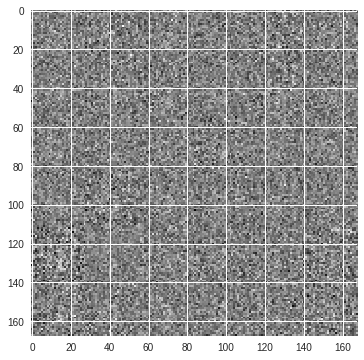

Step 2500: Generator Loss: 0.778535, Discriminator Loss: -0.193117


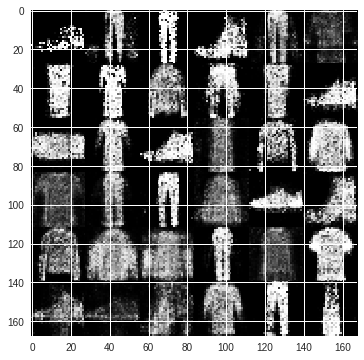

Step 5000: Generator Loss: 0.563745, Discriminator Loss: -0.237328


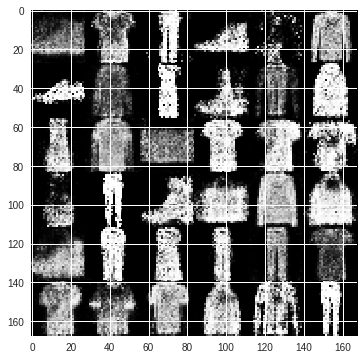

Step 7500: Generator Loss: 0.637642, Discriminator Loss: -0.110522


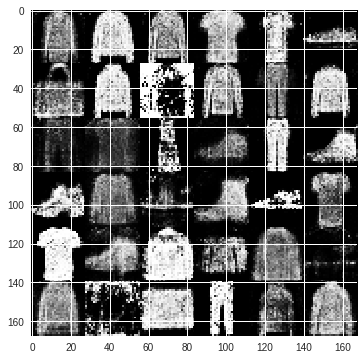

Step 10000: Generator Loss: 0.734754, Discriminator Loss: -0.249444


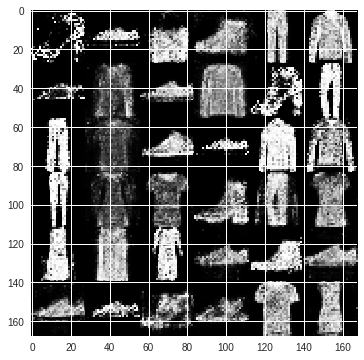

Step 12500: Generator Loss: 0.611481, Discriminator Loss: -0.175603


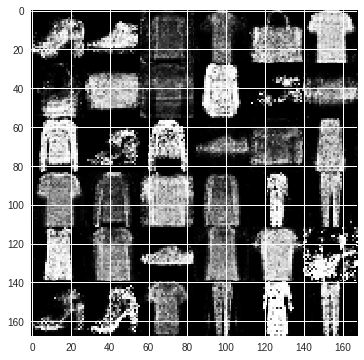

Step 15000: Generator Loss: 0.707011, Discriminator Loss: -0.247860


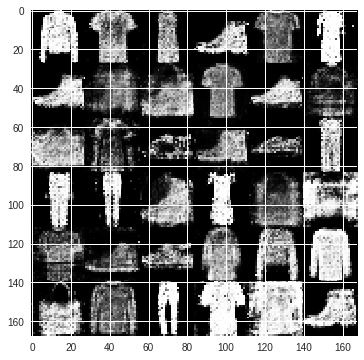

Step 17500: Generator Loss: 0.935269, Discriminator Loss: -0.278411


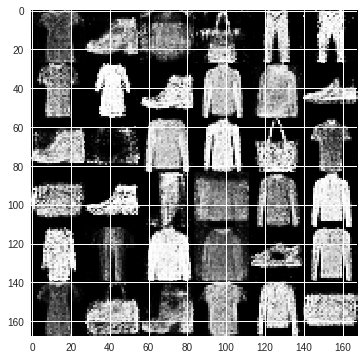

Step 20000: Generator Loss: 0.872695, Discriminator Loss: -0.326163


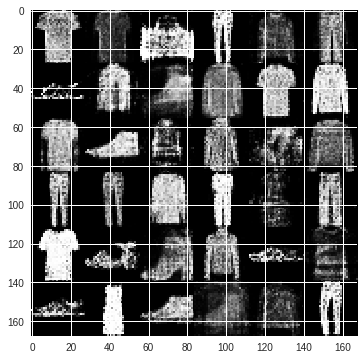

Step 22500: Generator Loss: 0.829664, Discriminator Loss: -0.305479


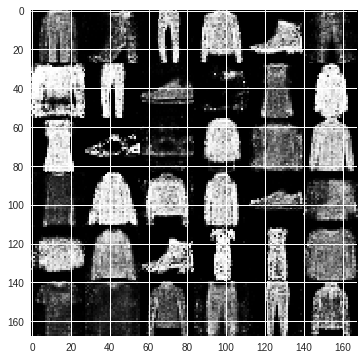

Step 25000: Generator Loss: 1.424468, Discriminator Loss: -0.455609


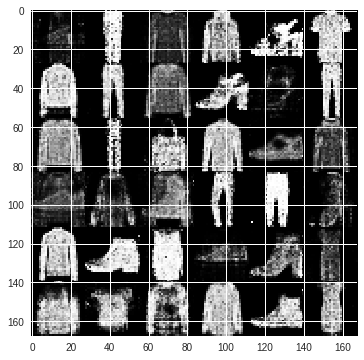

Step 27500: Generator Loss: 1.115281, Discriminator Loss: -0.237496


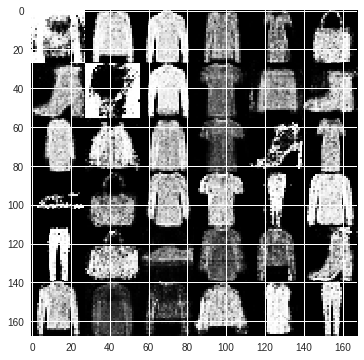

Step 30000: Generator Loss: 1.374310, Discriminator Loss: -0.419751


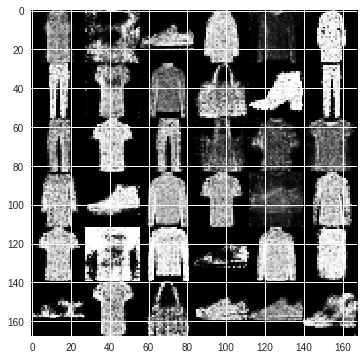

Step 32500: Generator Loss: 1.125441, Discriminator Loss: -0.415289


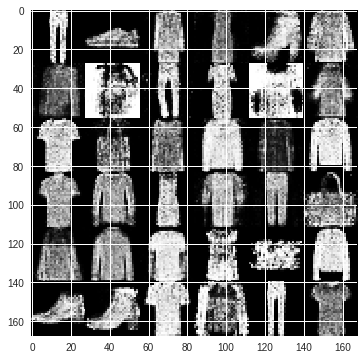

Step 35000: Generator Loss: 1.366315, Discriminator Loss: -0.451435


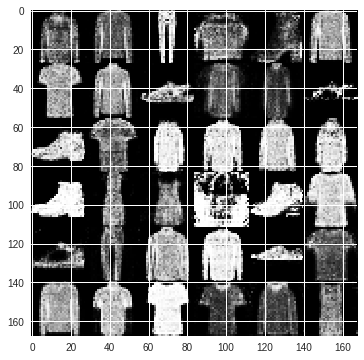

Step 37500: Generator Loss: 1.234816, Discriminator Loss: -0.441483


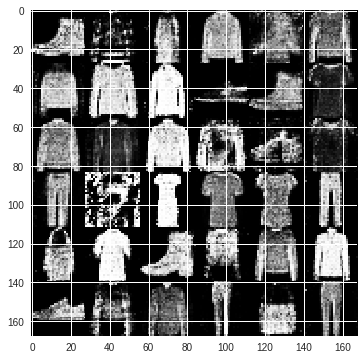

Step 40000: Generator Loss: 1.712964, Discriminator Loss: -0.480740


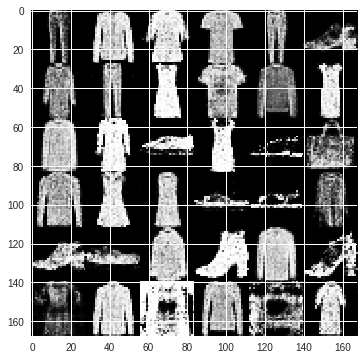

Step 42500: Generator Loss: 1.700262, Discriminator Loss: -0.479265


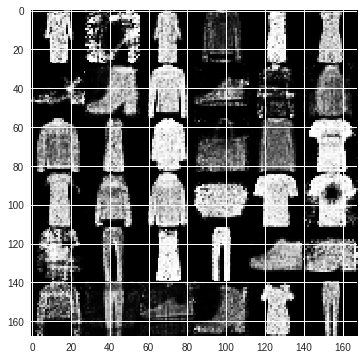

Step 45000: Generator Loss: 1.274183, Discriminator Loss: -0.406403


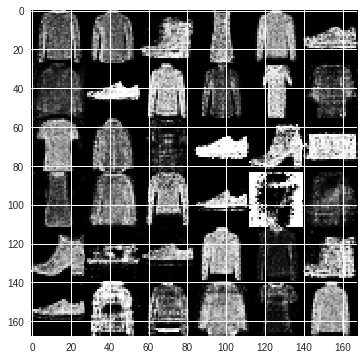

Step 47500: Generator Loss: 1.933035, Discriminator Loss: -0.584280


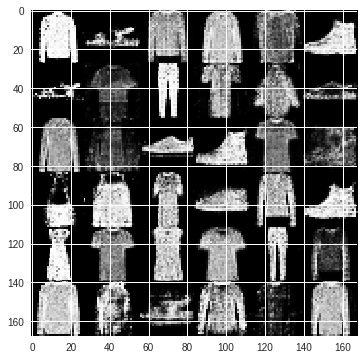

Step 50000: Generator Loss: 2.084689, Discriminator Loss: -0.586953


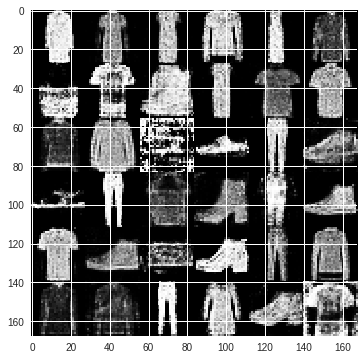

Step 52500: Generator Loss: 1.964618, Discriminator Loss: -0.568092


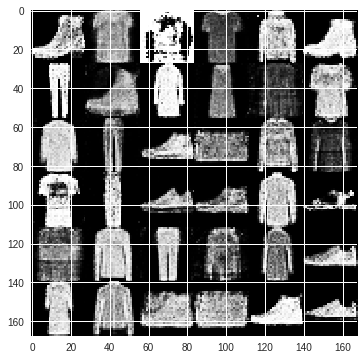

Step 55000: Generator Loss: 2.374744, Discriminator Loss: -0.494500


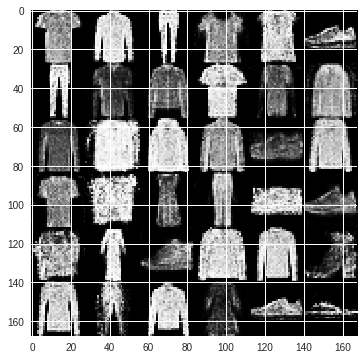

Step 57500: Generator Loss: 1.812893, Discriminator Loss: -0.484953


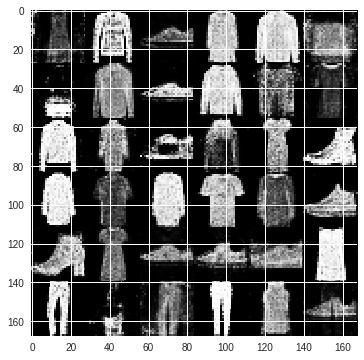

Step 60000: Generator Loss: 2.015948, Discriminator Loss: -0.585411


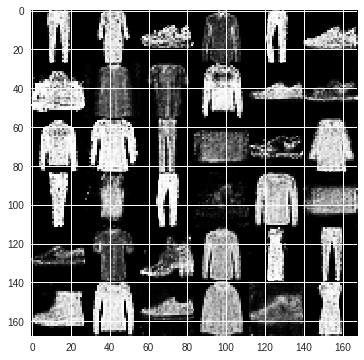

Step 62500: Generator Loss: 1.972193, Discriminator Loss: -0.583405


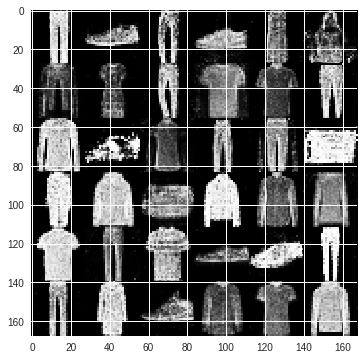

Step 65000: Generator Loss: 1.756995, Discriminator Loss: -0.597953


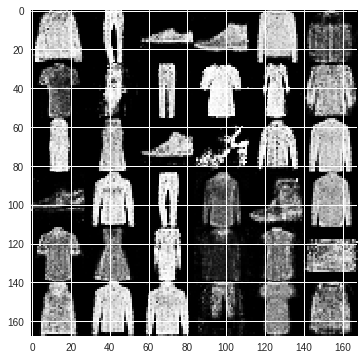

Step 67500: Generator Loss: 1.928220, Discriminator Loss: -0.568907


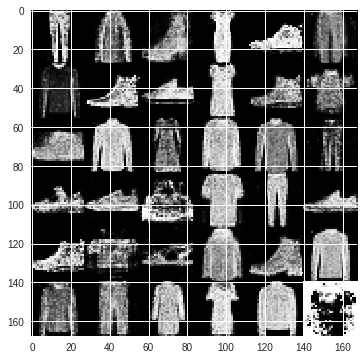

Step 70000: Generator Loss: 2.157465, Discriminator Loss: -0.550957


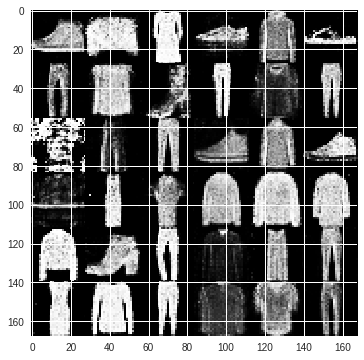

Step 72500: Generator Loss: 1.833771, Discriminator Loss: -0.677609


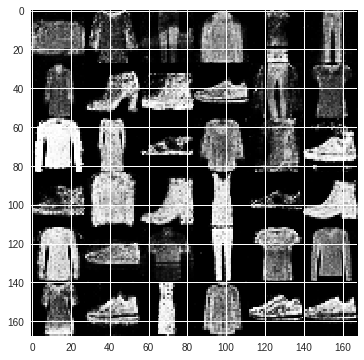

Step 75000: Generator Loss: 2.544476, Discriminator Loss: -0.608822


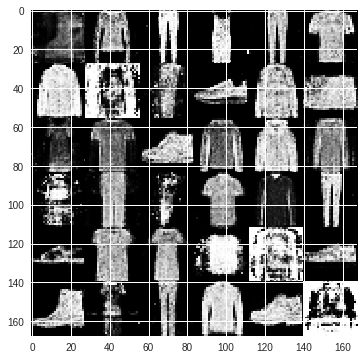

Step 77500: Generator Loss: 2.278728, Discriminator Loss: -0.562957


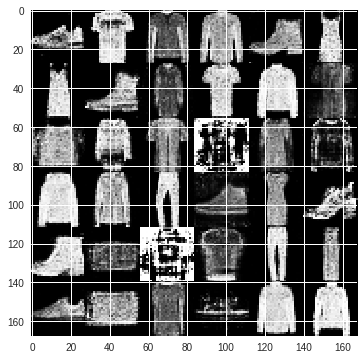

Step 80000: Generator Loss: 2.565100, Discriminator Loss: -0.666358


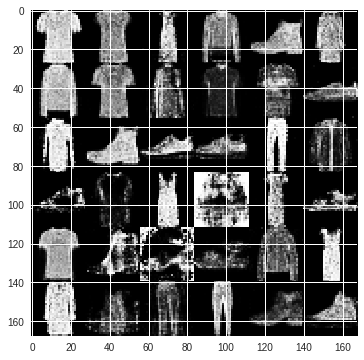

Step 82500: Generator Loss: 2.992171, Discriminator Loss: -0.756531


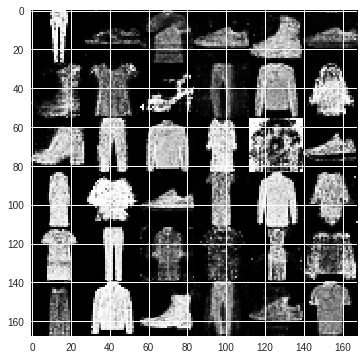

Step 85000: Generator Loss: 3.214330, Discriminator Loss: -0.682532


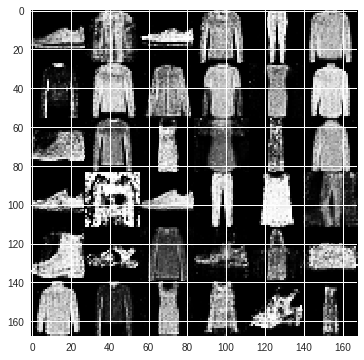

Step 87500: Generator Loss: 3.180190, Discriminator Loss: -0.711301


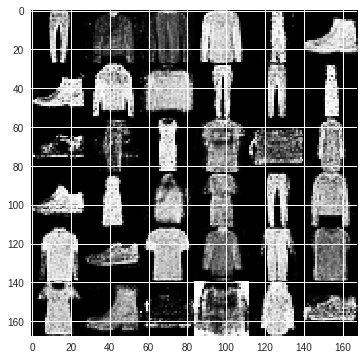

Step 90000: Generator Loss: 2.748959, Discriminator Loss: -0.690639


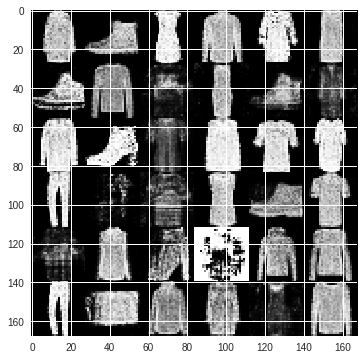

Step 92500: Generator Loss: 2.555824, Discriminator Loss: -0.729927


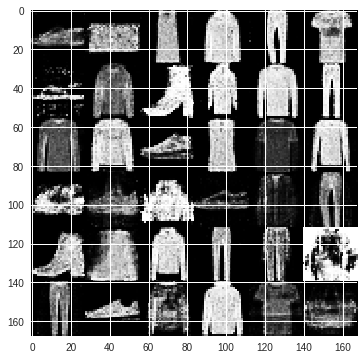

Step 95000: Generator Loss: 3.216609, Discriminator Loss: -0.709893


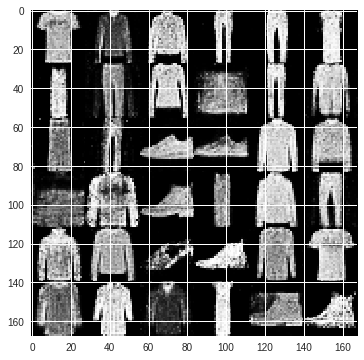

Step 97500: Generator Loss: 3.158453, Discriminator Loss: -0.777308


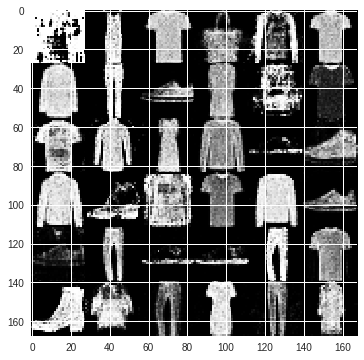

Step 100000: Generator Loss: 2.624340, Discriminator Loss: -0.719382


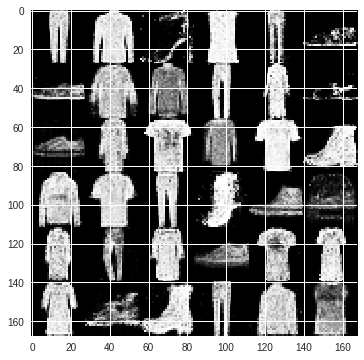

In [7]:
#### Training and Visualization ####

# Start a TF-Session and run the initializer.
sess = tf.Session()
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Get the next batch of FASHION-mnist (only images are needed, not labels)
    batch_x = next_batch(batch_size, x_train)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    batch_x = batch_x.reshape([-1, 28*28])
    batch_x = batch_x/255.   
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    
    ## Discriminator Training ##
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input : z, is_training:True})
    
    ## Generator Training ##
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    if i % 2500 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        plot_fun1()

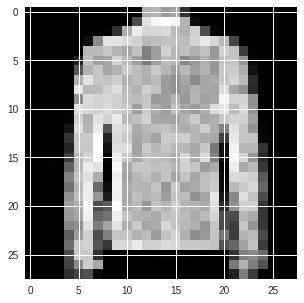

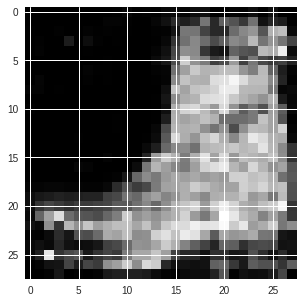

In [8]:
# Image Generator

plot_fun2()